# 5TF078 Deep Learning Course
## Excercise 2 Transfer Learning on Fashion-MNIST
Created by Tomas Nordström, Umeå University

Revisions:
* 2022-04-01 First revision based on earlier excercises /ToNo

#Cristina Zhang
#zhangjinting118@gmail.com


# First we initilize our Python environment

In [ ]:
#### Set up tests to know if we are running Colab or Kaggle
import sys

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [ ]:
# Set up Keras/Tensorflow framework
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # Also tensorflow, jax,pytorch for Keras 3.0

import keras
print('Keras version:', keras.__version__)

# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

Keras version: 3.5.0
TensorFlow version: 2.17.1


In [ ]:
#### Additional helper libraries
import pandas as pd
import numpy as np
import time
import sklearn
import tensorflow_datasets as tfds

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
#### Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     if IS_COLAB or IS_KAGGLE:
         print("Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ea31e3a2-2975-4f6a-5472-dd2f847badab)


# Set up the needed data sets, its preprocessing, and making it into a stream.

## Get hold of a data-set
In this exercise we will use Fashion MNIST dataset, which an alternative to MNIST (it is a little harder, but the image size is the same). This is available directly as a [Keras dataset](https://keras.io/datasets/). This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

Note that we split our data into **three** data sets: training, validation, testing; each with its own purpose.

In [ ]:
#### Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(class_names)

# Normalise images to a float between 0 and 1
train_images0 = train_images0.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Add empty color dimensions to images
train_images0 = np.expand_dims(train_images0, -1)
test_images = np.expand_dims(test_images, -1)

Note that the training labels are an integer between 0 and 9, which is not very good as outputs (or inputs) for DL models. A better approach will be to use a one-hot encoding. We can convert our label vectors to one-hot encoded matrices by using [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) `keras.utils.to_categorical(train_labels)`. This was used in Excercise 1.

In this Excercise we will achieve the same thing by using [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as a loss function instead of the [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). But note that for both cases we need our model to have as many output nodes as we have classes!

SparseCategoricalCrossentropy -- Computes the crossentropy loss between the labels and predictions. expect labels to be provided as ##integers##

CategoricalCrossentropy -- Computes the crossentropy loss between the labels and predictions. expect labels to be provided in a one_hot representation



## Set up the streaming of data

In [ ]:
#### Function to reformat data so that we can use a predefined network

# Later you will find out what is the minumum size
##################### TODO: MIGHT NEED AN UPDATE #####################
NEWIMG_WIDTH = 28*2
NEWIMG_HEIGHT = 28*2

# Define an in-stream transform function (normalize, add color-dim, gray2color, resize)
def ds_img_transform(images,labels):
    ##################### TODO: YOUR CODE STARTS HERE #####################
    images = tf.image.grayscale_to_rgb(images) #28*28*1--> 28*28*3
    images = tf.image.resize(images, [NEWIMG_HEIGHT, NEWIMG_WIDTH]) #56*56*3
    ##################### TODO: YOUR CODE ENDS HERE #######################
    return images,labels

In [ ]:
#### Get the three datasets (train, validation and test) from our data
##################### TODO: CAN BE CHANGED #####################
batch_size = 128

# split training into training and validation
train_ds,val_ds = keras.utils.split_dataset((train_images0, train_labels0), right_size=0.2)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# https://www.tensorflow.org/guide/data_performance
# Apply image mapping and set up batching of our datasets
train_ds = train_ds.map(ds_img_transform, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds   =   val_ds.map(ds_img_transform, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds  =  test_ds.map(ds_img_transform, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=batch_size, drop_remainder=True)
print(train_ds)
print(val_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(128, 56, 56, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(128, 56, 56, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.uint8, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(128, 56, 56, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.uint8, name=None))>


## Explore the data
It is always advised to take a look at the data, especially after applying various modifications like in ds_img_transform above. But now the data is in datasets and we need to grab a batch by using `dataset.take()`

In [ ]:
for ex_images, ex_labels in test_ds.take(1):  # Take just one batch
    break  # We've extracted what we need

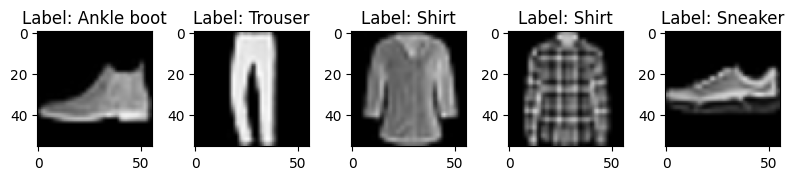

In [ ]:
#### Print a few of the test data images

# Index of the images to plot (within the batch)
iix = [0,2,4,7,9]

plt.figure(figsize=(8, 8))  # Set a larger figure size

for i,ix in enumerate(iix):
    # Plot images
    plt.subplot(1,len(iix), i+1)
    plt.imshow(ex_images[ix])
    plt.title(f"Label: {class_names[ex_labels[ix]]}")

plt.tight_layout()
plt.show()

# Transfer learning
Now follows the main topic of this exercise.

## Read in the model to transfer
You can find the available models at [Keras Applications](https://keras.io/api/applications/)

For this excersize you will use [VGG16](https://keras.io/api/applications/vgg/#vgg16-function).

When loading VGG, you must choose the correct values of some of the input parameters:
* weights='imagenet' --- Since we want to use the weights pretrained on the imagenet
* include_top=False --- This is False, we anyway will replace the "top" with our own layers. Note that they call the layers closest to the output the top layers.
* input_shape= **???** --- Set it to the same shape as the pictures have!

### Uppgift
Om du tittar på sidan för [VGG16](https://keras.io/api/applications/vgg/#vgg16-function), vilken är den minsta möjliga bildstorlek?

**Svar:**

It should have exactly 3 input channels, and width and height should be no smaller than 32.
 (32, 32, 3)

In [ ]:

##################### TODO: YOUR CODE STARTS HERE #####################
input_shape = (56,56,3)

#### Read in the model to transfer
tl_model = keras.applications.vgg16.VGG16(weights='imagenet',include_top=False, input_shape=input_shape)

# For now we are not training the parameters in the transfered model
tl_model.trainable = False
##################### TODO: YOUR CODE ENDS HERE #######################
tl_model.summary(show_trainable=True, line_length=100)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_17 (InputLayer)           │ (None, 56, 56, 3)             │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block1_conv1 (Conv2D)                 │ (None, 56, 56, 64)            │          1,792 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block1_conv2 (Conv2D)                 │ (None, 56, 56, 64)            │         36,928 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block1_pool (MaxPooling2D)            │ (None, 28, 28, 64)            │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block2_conv1 (Conv2D)                 │ (None, 28, 28, 128)           │         73,856 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block2_conv2 (Conv2D)                 │ (None, 28, 28, 128)           │        147,584 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block2_pool (MaxPooling2D)            │ (None, 14, 14, 128)           │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_conv1 (Conv2D)                 │ (None, 14, 14, 256)           │        295,168 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_conv2 (Conv2D)                 │ (None, 14, 14, 256)           │        590,080 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_conv3 (Conv2D)                 │ (None, 14, 14, 256)           │        590,080 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_pool (MaxPooling2D)            │ (None, 7, 7, 256)             │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block4_conv1 (Conv2D)                 │ (None, 7, 7, 512)             │      1,180,160 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block4_conv2 (Conv2D)                 │ (None, 7, 7, 512)             │      2,359,808 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block4_conv3 (Conv2D)                 │ (None, 7, 7, 512)             │      2,359,808 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block4_pool (MaxPooling2D)            │ (None, 3, 3, 512)             │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block5_conv1 (Conv2D)                 │ (None, 3, 3, 512)             │      2,359,808 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block5_conv2 (Conv2D)                 │ (None, 3, 3, 512)             │      2,359,808 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block5_conv3 (Conv2D)                 │ (None, 3, 3, 512)             │      2,359,808 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block5_pool (MaxPooling2D)            │ (None, 1, 1, 512)  

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Uppgift
Hur många parametrar finns i VGG16?

**Svar:**

 Total params: 14,714,688




**Analysera VGG-modellens lager**

Eftersom Fashion MNIST-bilderna är mycket små (28x28 original men inte mycket större efter skalning) kan vi inte effektivt använda hela modellen, eftersom den innehåller så många lager att de senare faltningslagren degenererar. Detta kan observeras i kolumnen Output Shape i model.summary. Där vi ser att lager på slutet får en "bildstorlek" som är av samma storlek som faltningskärnorna.

### Uppgift
Om du tittar på VGGs `model.summary` ovan, vid vilket lager kan det vara lämpligt att stanna? Notera detta kommer att bero på hur mycket du skalat upp inbilden. Det kommer också delvis bero på hur dina egna lager ser ut, som om du t.ex. vill ha ett eget faltningslager eller om du kanske direkt vill platta till modellen och bara köra kompakta lager.)

**Svar:**

Our input Size: (56, 56, 3) after scaling.
Stop at block3_pool and the output Shape: (7, 7, 256) for a balanced approach that retains meaningful features without excessive downsampling.

In [ ]:
##################### TODO: CHANGE!
name_of_last_TL_layer = 'block3_pool'

## Build a transfered model

In [ ]:
#### Build our own layers on top of the transfered model (use a functional definition as this is easier)

# Step 1. Get an output tensor of the last transfer-model layer that we want to include
x = tl_model.get_layer(name_of_last_TL_layer).output

##################### TODO: YOUR CODE STARTS HERE #####################
# Step 2. Stack our own layers on top
x = keras.layers.BatchNormalization(axis=-1)(x)
##### more layers
x = keras.layers.Flatten()(x)
##### more layers
##################### TODO: YOUR CODE ENDS HERE #######################
x = keras.layers.Dense(10, activation='softmax')(x)

# Creating new combined model. Note that this is NOT a Sequential() model.
model = keras.models.Model(inputs=tl_model.input, outputs=x)

print(model.summary(show_trainable=True, line_length=100))

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_17 (InputLayer)           │ (None, 56, 56, 3)             │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block1_conv1 (Conv2D)                 │ (None, 56, 56, 64)            │          1,792 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block1_conv2 (Conv2D)                 │ (None, 56, 56, 64)            │         36,928 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block1_pool (MaxPooling2D)            │ (None, 28, 28, 64)            │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block2_conv1 (Conv2D)                 │ (None, 28, 28, 128)           │         73,856 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block2_conv2 (Conv2D)                 │ (None, 28, 28, 128)           │        147,584 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block2_pool (MaxPooling2D)            │ (None, 14, 14, 128)           │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_conv1 (Conv2D)                 │ (None, 14, 14, 256)           │        295,168 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_conv2 (Conv2D)                 │ (None, 14, 14, 256)           │        590,080 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_conv3 (Conv2D)                 │ (None, 14, 14, 256)           │        590,080 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_pool (MaxPooling2D)            │ (None, 7, 7, 256)             │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ batch_normalization_52                │ (None, 7, 7, 256)             │          1,024 │    Y    │
│ (BatchNormalization)                  │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ flatten_8 (Flatten)                   │ (None, 12544)                 │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ dense_14 (Dense)                      │ (None, 10)                    │        125,450 │    Y    │
└───────────────────────────────────────┴───────────────────────────────┴────────────────┴─────────┘

 Total params: 1,861,962 (7.10 MB)

 Trainable params: 125,962 (492.04 KB)

 Non-trainable params: 1,736,000 (6.62 MB)

None


### Uppgift
Hur många träningsbara parametrar finns i din överförda modell?

**Svar:**

Trainable params: 125,962



In [ ]:
#### Compile the model (note SparseCategoricalCrossentropy as we have not converted labels)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.3e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
#### Training the model
# batch_size = 32 # Now set in datastream
epochs = 30

# Set callback functions to early stop training and save the best model so far
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3,restore_best_weights = True)]

start = time.perf_counter()
history = model.fit(train_ds,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=val_ds,
                    callbacks=callbacks)
end = time.perf_counter()
print(f"Time to run: {end - start:.2f}s",)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - acc: 0.8415 - loss: 0.4535 - val_acc: 0.9131 - val_loss: 0.2469
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - acc: 0.9268 - loss: 0.2114 - val_acc: 0.9241 - val_loss: 0.2218
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - acc: 0.9382 - loss: 0.1759 - val_acc: 0.9273 - val_loss: 0.2116
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - acc: 0.9451 - loss: 0.1546 - val_acc: 0.9278 - val_loss: 0.2122
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - acc: 0.9514 - loss: 0.1394 - val_acc: 0.9290 - val_loss: 0.2141
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - acc: 0.9557 - loss: 0.1281 - val_acc: 0.9294 - val_loss: 0.2187
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
Time to run: 102.39s


In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.3f}')

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.9238 - loss: 0.2269
Test accuracy: 0.925


## Uppgift
Notera antal parametrar som tränats, testnoggrannhet, körtid
(Notera att en noggrannhet på 91.5% är minimum för denna laboration!)

Vad kan man dra för slutsatser av dina körningar i denna del?
#ANSER:

| **Stopping Layer** | **Output Shape** | **Test Accuracy** | **Observation**                                |
|---------------------|------------------|-------------------|-----------------------------------------------|
| `block3_pool`       | (7, 7, 256)     | **92.4%**         | Optimal balance of feature extraction and spatial information. |
| `block4_pool`       | (3, 3, 512)     | **92.3%**         | Slightly reduced performance due to smaller feature map.       |
| `block5_pool`       | (1, 1, 512)     | **86.0%**         | Significant drop due to loss of spatial resolution.            |

These results demonstrate that selecting the appropriate transfer learning stopping layer is crucial for maximizing performance on datasets.

## Uppgift
När du nu funnit de bästa "topplagren" du kan finna, utvärdera din överförda model även med följande variationer:
* bildstorlek: utvärdera med följande bildstorlekar: minimistorlek, 28\*2x28\*2,  28\*3x28\*3.

Notera antal parametrar som tränats, testnoggrannhet, körtid

Vad kan man dra för slutsatser av detta?

Here I set up the stooping layer: block3_pool
### **Results Table**

| **Image Size**  | **Trainable Parameters** | **Test Accuracy** | **Runtime per Epoch** | **Observations**                             |
|-|---------|-------|-----------------|---------------------------------------------|
| **32x32x3**| 41,482                     | **91.5%**         | ~4-8s                   | Smallest size, less spatial detail retained. |
| **56x56x3**      | 125,962                     | **92.4%**         | ~12-18s                  | Best trade-off between accuracy and runtime. |
| **84x84x3**      | 256,522                     | **92.2%**         | ~33-39s                  | Higher runtime.  Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.   |

---
Conclusion is that 56x56 is the most efficient size for Fashion MNIST, achieving excellent accuracy (92.4%) with reasonable runtime.
Larger Sizes: While increasing image size to 84x84 has almost same accuracy as 56x56, the computational cost increases significantly, making it less practical. But early stopping helps a bit in total time consuming which we seted up this regularization.
When to Use Smaller Sizes:
For faster experiments or limited computational resources, 32x32 provides reasonable accuracy (91.5%) with much lower runtime.

# Del B

För överförd inlärning med VGG enligt ovan så ska du här slå på träning även för några av de importerade lagren och utvärdera hur det påverkar modellens prestanda. Lämpligen slår du först på alla lager för träning: "model.trainable = True". Om du sedan inte vill träna alla lager så kan du loopa över alla lager och göra "layer.trainable = False" där/om så behövs.
Notera att du kan lätt se vilka lager som är träningsbara mha `model.summary(show_trainable=True)`

Notera att du nog bör minska inlärningstakten (till typ 1e-4 -- 1e-5 för Adam) när du även tränar den överförda modellens parametrar, för annars kan den "glömma" för mycket av den förtränade modellen och modellen kan rent av bli sämre.

In [ ]:
# Enable training for all layers
model.trainable = True

# Display the model summary with trainable status
model.summary(show_trainable=True, line_length=100)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # Reduced learning rate
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

# Set callback functions to early stop training and save the best model so far
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy after fine-tuning all layers: {test_acc:.3f}")


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_17 (InputLayer)           │ (None, 56, 56, 3)             │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block1_conv1 (Conv2D)                 │ (None, 56, 56, 64)            │          1,792 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block1_conv2 (Conv2D)                 │ (None, 56, 56, 64)            │         36,928 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block1_pool (MaxPooling2D)            │ (None, 28, 28, 64)            │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block2_conv1 (Conv2D)                 │ (None, 28, 28, 128)           │         73,856 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block2_conv2 (Conv2D)                 │ (None, 28, 28, 128)           │        147,584 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block2_pool (MaxPooling2D)            │ (None, 14, 14, 128)           │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_conv1 (Conv2D)                 │ (None, 14, 14, 256)           │        295,168 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_conv2 (Conv2D)                 │ (None, 14, 14, 256)           │        590,080 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_conv3 (Conv2D)                 │ (None, 14, 14, 256)           │        590,080 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_pool (MaxPooling2D)            │ (None, 7, 7, 256)             │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ batch_normalization_52                │ (None, 7, 7, 256)             │          1,024 │    Y    │
│ (BatchNormalization)                  │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ flatten_8 (Flatten)                   │ (None, 12544)                 │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ dense_14 (Dense)                      │ (None, 10)                    │        125,450 │    Y    │
└───────────────────────────────────────┴───────────────────────────────┴────────────────┴─────────┘

 Total params: 2,113,888 (8.06 MB)

 Trainable params: 125,962 (492.04 KB)

 Non-trainable params: 1,736,000 (6.62 MB)

 Optimizer params: 251,926 (984.09 KB)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - acc: 0.9485 - loss: 0.1434 - val_acc: 0.9273 - val_loss: 0.2047
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - acc: 0.9543 - loss: 0.1296 - val_acc: 0.9285 - val_loss: 0.2021
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - acc: 0.9570 - loss: 0.1222 - val_acc: 0.9293 - val_loss: 0.2006
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - acc: 0.9599 - loss: 0.1162 - val_acc: 0.9300 - val_loss: 0.1998
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - acc: 0.9619 - loss: 0.1111 - val_acc: 0.9307 - val_loss: 0.1995
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - acc: 0.9636 - loss: 0.1065 - val_acc: 0.9305 - val_loss: 0.1994
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - acc: 0.9657 - loss: 0.1025 - val_acc: 0.9302 - val_loss: 0.1996
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - acc: 0.9677 - loss: 0.0988 - val_acc: 0.9302 - val_loss: 0.2000
Epoch 9/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Enable training for deeper layers only (e.g., block4 and block5)
for layer in model.layers:
    if "block4" in layer.name or "block5" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Display the model summary with trainable status
model.summary(show_trainable=True, line_length=100)


# Compile with a lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

# Set callback functions to early stop training and save the best model so far
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

# Train the model
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy after fine-tuning deeper layers: {test_acc:.3f}")


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_17 (InputLayer)           │ (None, 56, 56, 3)             │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block1_conv1 (Conv2D)                 │ (None, 56, 56, 64)            │          1,792 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block1_conv2 (Conv2D)                 │ (None, 56, 56, 64)            │         36,928 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block1_pool (MaxPooling2D)            │ (None, 28, 28, 64)            │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block2_conv1 (Conv2D)                 │ (None, 28, 28, 128)           │         73,856 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block2_conv2 (Conv2D)                 │ (None, 28, 28, 128)           │        147,584 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block2_pool (MaxPooling2D)            │ (None, 14, 14, 128)           │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_conv1 (Conv2D)                 │ (None, 14, 14, 256)           │        295,168 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_conv2 (Conv2D)                 │ (None, 14, 14, 256)           │        590,080 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_conv3 (Conv2D)                 │ (None, 14, 14, 256)           │        590,080 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ block3_pool (MaxPooling2D)            │ (None, 7, 7, 256)             │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ batch_normalization_52                │ (None, 7, 7, 256)             │          1,024 │    N    │
│ (BatchNormalization)                  │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ flatten_8 (Flatten)                   │ (None, 12544)                 │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ dense_14 (Dense)                      │ (None, 10)                    │        125,450 │    N    │
└───────────────────────────────────────┴───────────────────────────────┴────────────────┴─────────┘

 Total params: 2,113,888 (8.06 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,861,962 (7.10 MB)

 Optimizer params: 251,926 (984.09 KB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - acc: 0.9601 - loss: 0.1117 - val_acc: 0.9305 - val_loss: 0.1994
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - acc: 0.9601 - loss: 0.1117 - val_acc: 0.9305 - val_loss: 0.1994
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - acc: 0.9601 - loss: 0.1117 - val_acc: 0.9305 - val_loss: 0.1994
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - acc: 0.9601 - loss: 0.1117 - val_acc: 0.9305 - val_loss: 0.1994
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - acc: 0.9219 - loss: 0.2137
Test accuracy after fine-tuning deeper layers: 0.925


Selective Fine-Tuning is Sufficient:
For Fashion MNIST, fine-tuning block3_pool achieves the same performance as before, with fewer epochs and reduced computational cost.


# Del X (VG uppgift)

För denna deluppgift ska du ersätta VGG16 med Xception https://keras.io/api/applications/xception/ som bas för överförd inlärning och utvärdera den resulterande modellen på vårt Fashion-MNIST problem. Notera att Xception har en annan storlek som minsta möjliga storlek för inbilderna. Då modellen har 126 lager så kommer vi bara använda en del av alla dess lager på våra små bilder. Välj ett lämplig antal lager av Xceptionmodellen och motivera varför du inte använder fler. Utvärdera Xception och jämför med när du använde VGG16.

input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (299, 299, 3). It should have exactly 3 inputs channels, and width and height should be no smaller than 71. E.g. (150, 150, 3) would be one valid value.

In [ ]:
def ds_img_transform(images, labels):
    # Resize images to (71, 71, 3)
    images = tf.image.grayscale_to_rgb(images)
    images_resized = tf.image.resize(images, [71, 71])  # Resize to 71x71
    return images_resized, labels

batch_size = 128


In [ ]:
train_ds,val_ds = keras.utils.split_dataset((train_images0, train_labels0), right_size=0.2)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_ds = (train_ds.map(ds_img_transform, num_parallel_calls=tf.data.AUTOTUNE)
                    .batch(batch_size=batch_size)
                    .prefetch(tf.data.AUTOTUNE))

val_ds = (val_ds.map(ds_img_transform, num_parallel_calls=tf.data.AUTOTUNE)
                  .batch(batch_size=batch_size)
                  .prefetch(tf.data.AUTOTUNE))

test_ds = (test_ds.map(ds_img_transform, num_parallel_calls=tf.data.AUTOTUNE)
                   .batch(batch_size=batch_size)
                   .prefetch(tf.data.AUTOTUNE))


In [ ]:
from tensorflow.keras.applications import Xception

# Set input shape to match Xception's minimum requirement
input_shape = (71, 71, 3)

# Load the Xception model without top layers
xception_base = Xception(
    weights='imagenet',  # Pre-trained on ImageNet
    include_top=False,   # Exclude the fully connected layers
    input_shape=input_shape
)

# Freeze all layers in the base model
xception_base.trainable = False

# Display model summary for reference
xception_base.summary(show_trainable=True, line_length=100)


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape         ┃       Param # ┃ Connected to         ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_18           │ (None, 71, 71, 3)    │             0 │ -                    │    -    │
│ (InputLayer)             │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ block1_conv1 (Conv2D)    │ (None, 35, 35, 32)   │           864 │ input_layer_18[0][0] │    N    │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ block1_conv1_bn          │ (None, 35, 35, 32)   │           128 │ block1_conv1[0][0]   │    N    │
│ (BatchNormalization)     │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ block1_conv1_act         │ (None, 35, 35, 32)   │             0 │ block1_conv1_bn[0][… │    -    │
│ (Activation)             │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ block1_conv2 (Conv2D)    │ (None, 33, 33, 64)   │        18,432 │ block1_conv1_act[0]… │    N    │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ block1_conv2_bn          │ (None, 33, 33, 64)   │           256 │ block1_conv2[0][0]   │    N    │
│ (BatchNormalization)     │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ block1_conv2_act         │ (None, 33, 33, 64)   │             0 │ block1_conv2_bn[0][… │    -    │
│ (Activation)             │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ block2_sepconv1          │ (None, 33, 33, 128)  │         8,768 │ block1_conv2_act[0]… │    N    │
│ (SeparableConv2D)        │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ block2_sepconv1_bn       │ (None, 33, 33, 128)  │           512 │ block2_sepconv1[0][… │    N    │
│ (BatchNormalization)     │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ block2_sepconv2_act      │ (None, 33, 33, 128)  │             0 │ block2_sepconv1_bn[… │    -    │
│ (Activation)             │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ block2_sepconv2          │ (None, 33, 33, 128)  │        17,536 │ block2_sepconv2_act… │    N    │
│ (SeparableConv2D)        │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ block2_sepconv2_bn       │ (None, 33, 33, 128)  │           512 │ block2_sepconv2[0][… │    N    │
│ (BatchNormalization)     │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ conv2d_44 (Conv2D)       │ (None, 17, 17, 128)  │         8,192 │ block1_conv2_act[0]… │    N    │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ block2_pool              │ (None, 17, 17, 128)  │          

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout

# Get the output of the chosen layer
x = xception_base.get_layer("block3_pool").output

# Add custom layers
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(10, activation='softmax')(x)  # Output layer for 10 classes

# Create the final model
model = Model(inputs=xception_base.input, outputs=x)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Small learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Show trainable summary
model.summary(show_trainable=True)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_18         │ (None, 71, 71, 3)    │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1 (Conv2D)  │ (None, 35, 35, 32)   │          864 │ input_layer_18[0][… │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1_bn        │ (None, 35, 35, 32)   │          128 │ block1_conv1[0][0]  │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1_act       │ (None, 35, 35, 32)   │            0 │ block1_conv1_bn[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2 (Conv2D)  │ (None, 33, 33, 64)   │       18,432 │ block1_conv1_act[0… │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2_bn        │ (None, 33, 33, 64)   │          256 │ block1_conv2[0][0]  │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2_act       │ (None, 33, 33, 64)   │            0 │ block1_conv2_bn[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv1        │ (None, 33, 33, 128)  │        8,768 │ block1_conv2_act[0… │    N    │
│ (SeparableConv2D)      │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv1_bn     │ (None, 33, 33, 128)  │          512 │ block2_sepconv1[0]… │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2_act    │ (None, 33, 33, 128)  │            0 │ block2_sepconv1_bn… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2        │ (None, 33, 33, 128)  │       17,536 │ block2_sepconv2_ac… │    N    │
│ (SeparableConv2D)      │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2_bn     │ (None, 33, 33, 128)  │          512 │ block2_sepconv2[0]… │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_44 (Conv2D)     │ (None, 17, 17, 128)  │        8,192 │ block1_conv2_act[0… │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_pool            │ (None, 17, 17, 128)  │            0 │ block2_sepconv2_bn… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├──────────────────────

 Total params: 2,816,170 (10.74 MB)

 Trainable params: 2,656,138 (10.13 MB)

 Non-trainable params: 160,032 (625.12 KB)

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

# Train the model
history = model.fit(
    train_ds,  # Ensure images are resized to (71, 71)
    epochs=30,
    validation_data=val_ds,
    callbacks=callbacks
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy using Xception: {test_acc:.3f}")


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.7951 - loss: 0.6149 - val_accuracy: 0.9148 - val_loss: 0.2362
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.8960 - loss: 0.3000 - val_accuracy: 0.9261 - val_loss: 0.2105
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9101 - loss: 0.2602 - val_accuracy: 0.9268 - val_loss: 0.2053
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9197 - loss: 0.2280 - val_accuracy: 0.9250 - val_loss: 0.2097
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9225 - loss: 0.2145 - val_accuracy: 0.9334 - val_loss: 0.1909
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9280 - loss: 0.2013 - val_accuracy: 0.9361 - val_loss: 0.1811
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9326 - loss: 0.1848 - val_accuracy: 0.9352 - val_loss: 0.1850
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9354 - loss: 0.1717 - val_a

# För Alla Delar
Sammanställ dina resultat och gör en analys om hur de olika modellerna beter sig, speciellt mellan de modeller du har prövat i denna laboration, men även mot dina resultat i Laboration 1.

Using stopping layer *block3_pool* :

| **Model**   | **Test Accuracy** | **Observations**                             |
|-------------|-------------------|---------------------------------------------|
| **VGG16**   | 92.4%             | Slightly lower accuracy; simpler architecture. |
| **Xception**| 93.5%             | Higher accuracy; modern and efficient design. |

---

The results demonstrate that Xception's architecture is well-suited for transfer learning on Fashion-MNIST, achieving excellent accuracy with modest computational trade-offs. For tasks requiring high performance on small datasets, Xception proves to be a superior choice compared to older models like VGG16.